### Data Loading and Label Mapping

In [11]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from scraping_selenium import people_also_ask
import re

In [12]:
df = pd.read_csv('Test_dataset(FINAL).csv')
df

,Headline,Source,Question_phi,Question_Mistral,Label
0,NASA’s Perseverance rover finds its first poss...,sciencenews.org,"""Has NASA's Perseverance rover discovered evid...","""Has NASA officially announced the discovery o...",True
1,Sepsis tests take days putting patients at ri...,sciencenews.org,"""What is the current average wait time for sep...","""Is there a recent study or research that show...",True
2,Nasa's DART asteroid unlocks complex history o...,https://timesofindia.indiatimes.com/,"""What is the history of NASA's DART mission an...","""Has NASA's DART mission provided evidence of ...",True
3,Say goodbye to back pain patients go for adva...,https://timesofindia.indiatimes.com/,"""What are the benefits of advanced endoscopy s...","""Has 'advanced endoscopy spine surgery for sci...",True
4,Neurodivergent children more likely to develop...,https://timesofindia.indiatimes.com/,"""What does the study find about the likelihood...","""Is there a peer-reviewed study titled 'Neurod...",True
...,...,...,...,...,...
683,"""Google's parent company faces UK investigatio...",Synthetically Generated,"""Has Google's parent company been investigated...","""Has Alphabet Inc., Google's parent company, b...",False
684,"""Intel announces hiring spree to fund recovery...",Synthetically Generated,"""What is the current hiring status of Intel as...","""Has Intel announced a hiring spree to fund re...",False
685,"""Ola Electric IPO grey market premium skyrocke...",Synthetically Generated,"""What is the current grey market premium for O...","""Has the Ola Electric IPO grey market premium ...",False
686,"""Japan's Nikkei 225 Index Soars 12.4%, Its Big...",Synthetically Generated,"""What was the percentage increase in Japan's N...","1. ""Is there a news article from a reliable so...",False


In [13]:
# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Headline,Source,Question_phi,Question_Mistral,Label
0,"""Mercury's secrets: Is a diamond layer actuall...",Synthetically Generated,"""What evidence supports the existence of a dia...","""Has NASA or any other reputable space agency ...",False
1,Putin’s Hungarian ally Orban draws EU ire over...,https://www.cnbc.com,"""What is the nature of the 'peace mission' tha...","""Has Hungarian Prime Minister Viktor Orban met...",True
2,Climate change causing more change in rainfall...,thehindu.com,"""What evidence do scientists have that links c...","""Has a recent peer-reviewed study by scientist...",True
3,"""J.K. Rowling and Elon Musk Praise Olympics Fo...",Synthetically Generated,"""What did J.K. Rowling and Elon Musk say about...","""Has J.K. Rowling and Elon Musk publicly prais...",False
4,"""Lithium deposits overestimated at 600 tonnes ...",Synthetically Generated,"""How much lithium was actually discovered in K...","""Has the Indian government officially confirme...",False


In [14]:
df['Label'].value_counts()

Label
False    344
True     344
Name: count, dtype: int64

<Axes: ylabel='Label'>

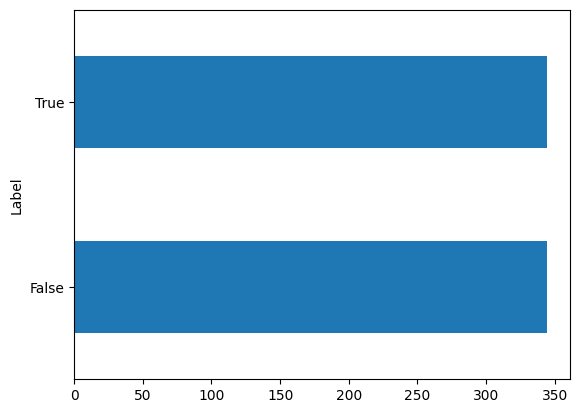

In [15]:
df['Label'].value_counts().plot(kind='barh')

Article Pipeline Utility

In [16]:

def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []
    if search_query_results:
        for results in search_query_results:
            try:
                # Send a request to the URL and get the HTML content
                response = requests.get(results)
                soup = BeautifulSoup(response.content, 'lxml')

                currentp = ""
                # Scrape <p> tags
                p_tags = soup.find_all('p')
                for p in p_tags:
                    currentp += p.text
                currentp = currentp[:1000]
                currentp = currentp.replace('\n', ' ')
                currentp = re.sub(r'\s+', ' ', currentp)
                article_content.append(currentp)

                currenth1 = ""
                # Scrape <h1> tags
                h1_tags = soup.find_all('h1')
                for h1 in h1_tags:
                    currenth1 += h1.text

                article_titles.append(currenth1)

            except Exception as e:
                print(f"An error occurred: {e}")
    return article_titles, article_content


# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

### LLM Pipeline

In [17]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

In [20]:
#To answer the question generated by LLM via google
def google_search(query):
    headers = {
        'User-agent':
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.67 Safari/537.36'
    }
    
    # Perform the Google search
    search_url = f'https://www.google.com/search?q={query}'
    html = requests.get(search_url, headers=headers)
    
    # Parse the HTML response
    soup = BeautifulSoup(html.text, 'html.parser')
    
    #extract answer from summary answer on google
    if soup.select_one('.hgKElc'):
        answer = soup.select_one('.hgKElc').text 

    # Extract the answer (assuming it's in a specific class) -> QUICK ANSWER BOX
    elif soup.select_one('.DI6Ufb'):
        answer = soup.select_one('.DI6Ufb')
        answer = answer.find(class_='Z0LcW t2b5Cf').text
        answer=query+' '+answer
    
    elif not soup.select_one('.DI6Ufb'):
        result=people_also_ask(search_url)
        # print("Result of the Scraping",result)
        if len(result)==2:
            answer=f'{result[0]} {result[1]}'
        else:
            #incase people also asked also comes empty we revert to the article pipeline
            scraped_df = make_data(query)
            scraped_df.dropna(inplace=True)

            # Convert the 'Content' column to strings
            scraped_df['Content'] = scraped_df['Content'].astype(str)

            # Sort the DataFrame based on the length of the strings in the 'Content' column
            scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

            if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
                #Could not retrieve articles related to headline, Could possibly be a false claim OR Scraper got blocked/forbidden
                return str('Cannot retrieve articles, most likely to be false')

            scraped_content = (
            f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
            answer = scraped_content
    return answer

In [18]:
def FactCC_Phi(input_headline ,Phi_generated_question):
    quickSearchAnswer = google_search(Phi_generated_question)

    #compare scraped info as source and headline as the claim
    ans = pipe([[[quickSearchAnswer,Phi_generated_question]]], truncation=True, padding='max_length')

    print('Input headline : ', input_headline)
    print('Phi-3 Generated Question : ', Phi_generated_question)
    print('Scraped Answer : ', quickSearchAnswer)
    if ans[0]['label'] == 'CORRECT':
        return True
    else:
        return False

In [21]:
model_decision = FactCC_Phi(df['Headline'][0],df['Question_phi'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if (model_decision) == (actual_decision):
    print('Correct Decision')
else:
    print('Incorrect Decision')

People Also Asked questions dont exist for this category
An error occurred: 429 Client Error: Too Many Requests for url: https://www.google.com/sorry/index?continue=https://www.google.com/search%3Fq%3D%2522What%252Bevidence%252Bsupports%252Bthe%252Bexistence%252Bof%252Ba%252Bdiamond%252Blayer%252Bbeneath%252BMercury%2527s%252Bsurface%253F%2522%26num%3D3%26hl%3Den%26start%3D0&hl=en&q=EgQxKxnwGNKnzrUGIjBK1mpJ9ARiT9H0tETB36Jy9S_XEgsvd_xFtIa6VosnEDenhyK8wfhd34eIn6y9UacyAXJaAUM
Input headline :  "Mercury's secrets: Is a diamond layer actually hiding under the planet's surface?"
Phi-3 Generated Question :  "What evidence supports the existence of a diamond layer beneath Mercury's surface?"
Scraped Answer :  Cannot retrieve articles, most likely to be false
False False
Correct Decision


In [ ]:
df = df[:10] #For testing

In [ ]:
# Initialize lists to store predictions and actual values
predictions = []
actuals = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    model_decision = FactCC_Phi(row['Headline'],row['Question_phi'])
    actual_decision = row['Label']
    predictions.append((model_decision))
    actuals.append((actual_decision))
    print(f"Index: {index}, Model Decision: {model_decision}, Actual Decision: {actual_decision}")
    print(f"------------------------------------------------------------------------------------")
    time.sleep(5)

# Calculate the metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, pos_label=True)
recall = recall_score(actuals, predictions, pos_label=True)
f1 = f1_score(actuals, predictions, pos_label=True)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
